# Generative Adversarial Network (GAN) para la generación de imágenes de perros y gatos

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
from torchvision.utils import save_image
import torchvision.utils as vutils
from torch.utils.data import Dataset
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Usando el dispositivo:', device)

Usando el dispositivo: cuda


## Data Augmentation

In [3]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [4]:
class FilteredImageDataset(Dataset):
    def __init__(self, image_dir, keyword, transform=None):
        self.image_paths = [f for f in glob.glob(os.path.join(image_dir, '*'))
                            if os.path.basename(f).startswith(keyword)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [5]:
data_dir = 'data_d'

dogs_dataset = FilteredImageDataset(data_dir, 'dog', transform=transform)
cats_dataset = FilteredImageDataset(data_dir, 'cat', transform=transform)

In [6]:
batch_size = 64

dogs_loader = torch.utils.data.DataLoader(dogs_dataset, batch_size=batch_size, shuffle=True)
cats_loader = torch.utils.data.DataLoader(cats_dataset, batch_size=batch_size, shuffle=True)

## Generador

In [7]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Entrada Z: (nz) x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),  # (ngf*8) x 4 x 4
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # (ngf*8) x 4 x 4 -> (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # (ngf*4) x 8 x 8 -> (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # (ngf*2) x 16 x 16 -> (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # (ngf) x 32 x 32 -> (nc) x 64 x 64
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()  # Salida en el rango [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

## Discriminador

In [8]:
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Entrada: (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),  # (ndf) x 32 x 32
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf) x 32 x 32 -> (ndf*2) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*2) x 16 x 16 -> (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*4) x 8 x 8 -> (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*8) x 4 x 4 -> 1 x 1 x 1
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Salida entre [0, 1]
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [9]:
# Parámetros
nz = 100  # Tamaño del vector de ruido
ngf = 64  # Tamaño de las características en el generador
ndf = 64  # Tamaño de las características en el discriminador
nc = 3    # Número de canales (RGB)

# perros
netG_dogs = Generator(nz, ngf, nc).to(device)
netD_dogs = Discriminator(nc, ndf).to(device)

# gatos
netG_cats = Generator(nz, ngf, nc).to(device)
netD_cats = Discriminator(nc, ndf).to(device)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02) 
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02) 
        nn.init.constant_(m.bias.data, 0)

netG_dogs.apply(weights_init)
netD_dogs.apply(weights_init)
netG_cats.apply(weights_init)
netD_cats.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [10]:
criterion = nn.BCELoss()
lr = 0.0002
beta1 = 0.5

optimizerD_dogs = optim.Adam(netD_dogs.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG_dogs = optim.Adam(netG_dogs.parameters(), lr=lr, betas=(beta1, 0.999))

optimizerD_cats = optim.Adam(netD_cats.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG_cats = optim.Adam(netG_cats.parameters(), lr=lr, betas=(beta1, 0.999))

## Entrenamiento

### Perros

In [ ]:
num_epochs = 1500
real_label = 1.
fake_label = 0.

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

img_list_dogs = []
G_losses_dogs = []
D_losses_dogs = []

print("Iniciando entrenamiento de perros...")

for epoch in range(num_epochs):
    for i, data in enumerate(dogs_loader, 0):
        ############################
        # (1) Actualizar el Discriminador: maximizar log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Entrenamiento con batch real
        netD_dogs.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD_dogs(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Entrenamiento con batch falso
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG_dogs(noise)
        label.fill_(fake_label)
        output = netD_dogs(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD_dogs.step()

        ############################
        # (2) Actualizar el Generador: maximizar log(D(G(z)))
        ###########################
        netG_dogs.zero_grad()
        label.fill_(real_label)  # Etiquetas reales para las salidas falsas
        output = netD_dogs(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG_dogs.step()

        G_losses_dogs.append(errG.item())
        D_losses_dogs.append(errD.item())

        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dogs_loader)}]\t'
                  f'Pérdida_D: {errD.item():.4f}\tPérdida_G: {errG.item():.4f}\t'
                  f'D(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

    if (epoch % 5 == 0) or (epoch == num_epochs - 1):
        with torch.no_grad():
            fake = netG_dogs(fixed_noise).detach().cpu()
        img_list_dogs.append(vutils.make_grid(fake, padding=2, normalize=True))
        save_image(fake, f'dogs_epoch_{epoch:03d}.png', normalize=True)


Iniciando entrenamiento de perros...
[0/1500][0/196]	Pérdida_D: 0.6841	Pérdida_G: 6.5377	D(x): 0.7418	D(G(z)): 0.1538 / 0.0021
[0/1500][50/196]	Pérdida_D: 0.0683	Pérdida_G: 12.2938	D(x): 0.9501	D(G(z)): 0.0013 / 0.0000
[0/1500][100/196]	Pérdida_D: 1.4704	Pérdida_G: 6.4009	D(x): 0.4333	D(G(z)): 0.0029 / 0.0041
[0/1500][150/196]	Pérdida_D: 0.3009	Pérdida_G: 4.4302	D(x): 0.8175	D(G(z)): 0.0367 / 0.0171
[1/1500][0/196]	Pérdida_D: 0.1349	Pérdida_G: 6.2961	D(x): 0.9126	D(G(z)): 0.0247 / 0.0035
[1/1500][50/196]	Pérdida_D: 0.6483	Pérdida_G: 5.5744	D(x): 0.6242	D(G(z)): 0.0067 / 0.0076
[1/1500][100/196]	Pérdida_D: 0.1980	Pérdida_G: 5.5210	D(x): 0.8769	D(G(z)): 0.0366 / 0.0051
[1/1500][150/196]	Pérdida_D: 0.2755	Pérdida_G: 6.6382	D(x): 0.8404	D(G(z)): 0.0174 / 0.0036
[2/1500][0/196]	Pérdida_D: 0.3093	Pérdida_G: 6.8651	D(x): 0.9506	D(G(z)): 0.1999 / 0.0025
[2/1500][50/196]	Pérdida_D: 0.5816	Pérdida_G: 6.6664	D(x): 0.9377	D(G(z)): 0.3464 / 0.0033
[2/1500][100/196]	Pérdida_D: 0.4504	Pérdida_G: 3.34

### Gatos

In [ ]:
img_list_cats = []
G_losses_cats = []
D_losses_cats = []

print("Iniciando entrenamiento de gatos...")

for epoch in range(num_epochs):
    for i, data in enumerate(cats_loader, 0):
        ############################
        # (1) Actualizar el Discriminador: maximizar log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Entrenamiento con batch real
        netD_cats.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD_cats(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Entrenamiento con batch falso
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG_cats(noise)
        label.fill_(fake_label)
        output = netD_cats(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD_cats.step()

        ############################
        # (2) Actualizar el Generador: maximizar log(D(G(z)))
        ###########################
        netG_cats.zero_grad()
        label.fill_(real_label)  # Etiquetas reales para las salidas falsas
        output = netD_cats(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG_cats.step()

        G_losses_cats.append(errG.item())
        D_losses_cats.append(errD.item())

        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(cats_loader)}]\t'
                  f'Pérdida_D: {errD.item():.4f}\tPérdida_G: {errG.item():.4f}\t'
                  f'D(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

    if (epoch % 5 == 0) or (epoch == num_epochs - 1):
        with torch.no_grad():
            fake = netG_cats(fixed_noise).detach().cpu()
        img_list_cats.append(vutils.make_grid(fake, padding=2, normalize=True))
        save_image(fake, f'cats_epoch_{epoch:03d}.png', normalize=True)


Iniciando entrenamiento de gatos...
[0/1500][0/196]	Pérdida_D: 1.8670	Pérdida_G: 6.2302	D(x): 0.4806	D(G(z)): 0.5842 / 0.0028
[0/1500][50/196]	Pérdida_D: 0.2531	Pérdida_G: 7.6760	D(x): 0.8474	D(G(z)): 0.0048 / 0.0007
[0/1500][100/196]	Pérdida_D: 0.6331	Pérdida_G: 3.2267	D(x): 0.6978	D(G(z)): 0.0652 / 0.0642
[0/1500][150/196]	Pérdida_D: 0.4540	Pérdida_G: 6.1477	D(x): 0.9035	D(G(z)): 0.2529 / 0.0030
[1/1500][0/196]	Pérdida_D: 0.3451	Pérdida_G: 3.8675	D(x): 0.8344	D(G(z)): 0.1172 / 0.0307
[1/1500][50/196]	Pérdida_D: 0.7770	Pérdida_G: 12.5552	D(x): 0.6359	D(G(z)): 0.0005 / 0.0007
[1/1500][100/196]	Pérdida_D: 0.2677	Pérdida_G: 4.4367	D(x): 0.8625	D(G(z)): 0.0958 / 0.0202
[1/1500][150/196]	Pérdida_D: 0.2501	Pérdida_G: 7.2874	D(x): 0.9373	D(G(z)): 0.1186 / 0.0019
[2/1500][0/196]	Pérdida_D: 0.1948	Pérdida_G: 5.3589	D(x): 0.9484	D(G(z)): 0.1122 / 0.0350
[2/1500][50/196]	Pérdida_D: 0.4524	Pérdida_G: 7.4111	D(x): 0.9243	D(G(z)): 0.2589 / 0.0014
[2/1500][100/196]	Pérdida_D: 0.2353	Pérdida_G: 4.699

## Perdida

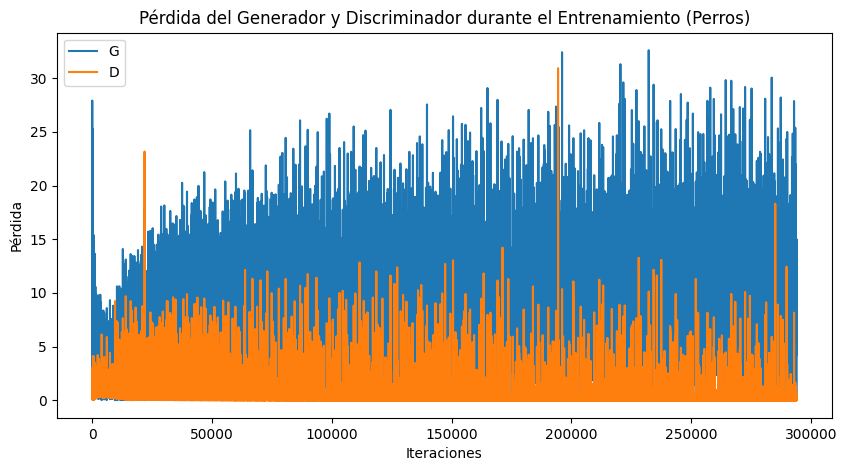

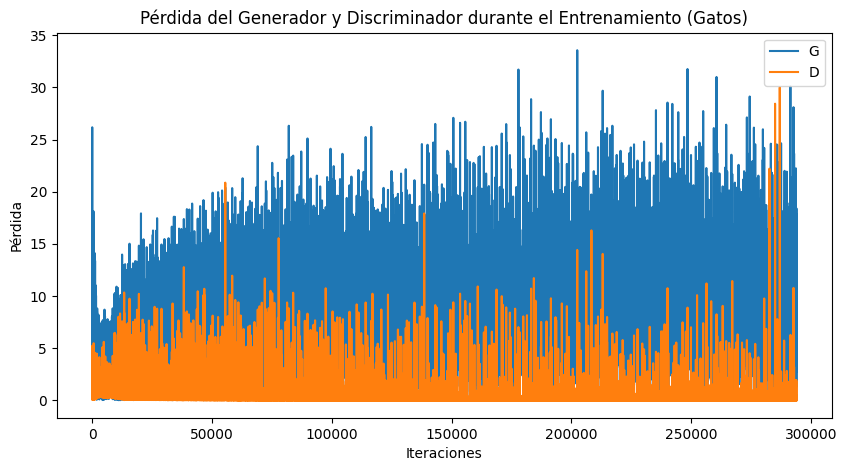

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Pérdida del Generador y Discriminador durante el Entrenamiento (Perros)")
plt.plot(G_losses_dogs, label="G")
plt.plot(D_losses_dogs, label="D")
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Pérdida del Generador y Discriminador durante el Entrenamiento (Gatos)")
plt.plot(G_losses_cats, label="G")
plt.plot(D_losses_cats, label="D")
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida")
plt.legend()
plt.show()

## Heatmaps

In [91]:
def generate_discriminator_saliency_map(discriminator, images):
    discriminator.eval()
    
    images = images.to(device)
    images.requires_grad = True

    outputs = discriminator(images)
    scores = outputs.mean()

    discriminator.zero_grad()
    scores.backward()

    saliency = images.grad.data.abs()
    saliency, _ = torch.max(saliency, dim=1) 
    average_saliency = saliency.mean(dim=0) 

    return average_saliency.cpu().numpy()

In [92]:
class GeneratorWithGradCAM(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(GeneratorWithGradCAM, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

        self.gradients = None
        self.activations = None

        def save_gradients_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def save_activations_hook(module, input, output):
            self.activations = output

        target_layer = self.main[6] 
        target_layer.register_forward_hook(save_activations_hook)
        target_layer.register_backward_hook(save_gradients_hook)

    def forward(self, input):
        return self.main(input)

In [93]:
def generate_generator_gradcam_heatmap(generator, discriminator, num_images):
    generator.eval()
    discriminator.eval()

    heatmaps = []

    for _ in range(num_images):
        noise = torch.randn(1, nz, 1, 1, device=device, requires_grad=True)
        fake_image = generator(noise)

        output = discriminator(fake_image)

        loss = output.mean()

        generator.zero_grad()
        discriminator.zero_grad()
        loss.backward(retain_graph=True)

        gradients = generator.gradients
        activations = generator.activations

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

        gradcam = torch.sum(weights * activations, dim=1)
        gradcam = F.relu(gradcam)

        gradcam = gradcam - gradcam.min()
        gradcam = gradcam / gradcam.max()
        heatmaps.append(gradcam.squeeze(0).cpu().detach().numpy())

    average_heatmap = np.mean(heatmaps, axis=0)
    return average_heatmap


In [94]:
num_images = 500
batch_size = 100

### Perros

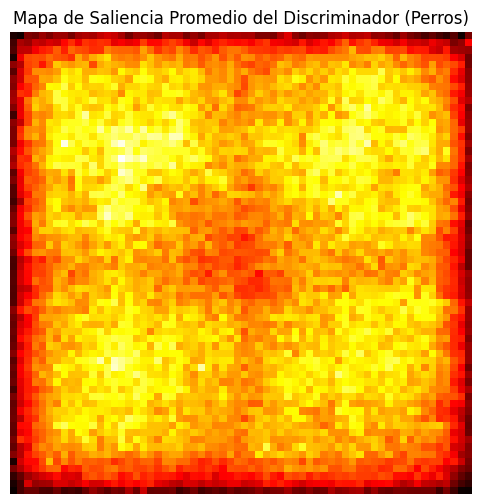

In [95]:
real_images = []
for data in dogs_loader:
    real_images.append(data)
    if len(real_images) * batch_size >= num_images:
        break
real_images = torch.cat(real_images)[:num_images]

average_saliency_dogs = generate_discriminator_saliency_map(netD_dogs_loaded, real_images)

plt.figure(figsize=(6,6))
plt.imshow(average_saliency_dogs, cmap='hot')
plt.title('Mapa de Saliencia Promedio del Discriminador (Perros)')
plt.axis('off')
plt.show()

c:\Users\TheKi\OneDrive - UVG\Semestre VIII\deep learning\env3.9\lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


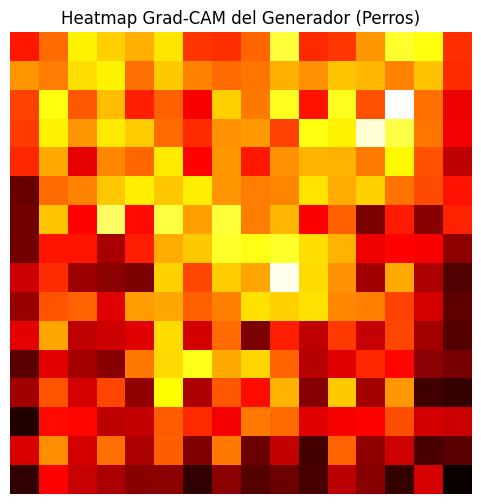

In [96]:
# Instanciar el generador modificado
netG_dogs_with_gradcam = GeneratorWithGradCAM(nz, ngf, nc).to(device)
netG_dogs_with_gradcam.load_state_dict(netG_dogs_loaded.state_dict())

# Generar el heatmap con Grad-CAM
num_images = 50  # Puedes ajustar este número
average_heatmap_dogs = generate_generator_gradcam_heatmap(netG_dogs_with_gradcam, netD_dogs_loaded, num_images)

# Visualizar el heatmap
plt.figure(figsize=(6,6))
plt.imshow(average_heatmap_dogs, cmap='hot')
plt.title('Heatmap Grad-CAM del Generador (Perros)')
plt.axis('off')
plt.show()


### Gatos

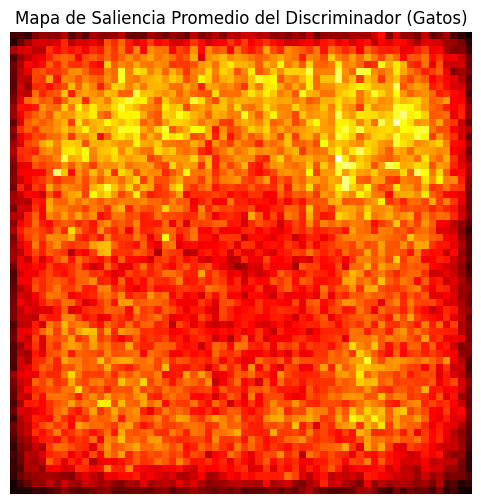

In [97]:
real_images = []
for data in cats_loader:
    real_images.append(data)
    if len(real_images) * batch_size >= num_images:
        break
real_images = torch.cat(real_images)[:num_images]

average_saliency_cats = generate_discriminator_saliency_map(netD_cats_loaded, real_images)

plt.figure(figsize=(6,6))
plt.imshow(average_saliency_cats, cmap='hot')
plt.title('Mapa de Saliencia Promedio del Discriminador (Gatos)')
plt.axis('off')
plt.show()

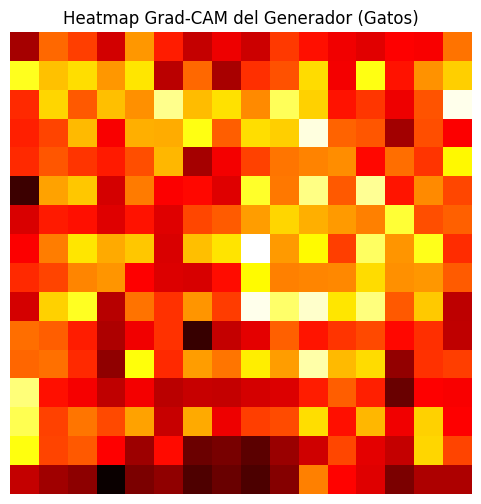

In [102]:
netG_cats_with_gradcam = GeneratorWithGradCAM(nz, ngf, nc).to(device)
netG_cats_with_gradcam.load_state_dict(netG_cats_loaded.state_dict())

average_heatmap_cats = generate_generator_gradcam_heatmap(netG_cats_with_gradcam, netD_cats_loaded, num_images)

plt.figure(figsize=(6,6))
plt.imshow(average_heatmap_cats, cmap='hot')
plt.title('Heatmap Grad-CAM del Generador (Gatos)')
plt.axis('off')
plt.show()

## Inception Score

### Perros

In [ ]:
num_images = 50 
batch_size = 50 

fake_images_dogs = []
with torch.no_grad():
    for _ in range(num_images // batch_size):
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG_dogs(noise).cpu()
        fake_images_dogs.append(fake)
fake_images_dogs = torch.cat(fake_images_dogs)

is_metric = InceptionScore(normalize=True)
is_dogs = is_metric(fake_images_dogs)
print(f'Inception Score para perros: {is_dogs[0]:.4f} ± {is_dogs[1]:.4f}')

c:\Users\TheKi\OneDrive - UVG\Semestre VIII\deep learning\env3.9\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


Inception Score para perros: 1.1104 ± 0.0478


### Gatos

In [166]:
fake_images_cats = []
with torch.no_grad():
    for _ in range(num_images // batch_size):
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG_cats(noise).cpu()
        fake_images_cats.append(fake)
fake_images_cats = torch.cat(fake_images_cats)

is_cats = is_metric(fake_images_cats)
print(f'Inception Score para gatos: {is_cats[0]:.4f} ± {is_cats[1]:.4f}')


Inception Score para gatos: 1.0981 ± 0.0577


### Frechet Inception Distance

### Perros

In [ ]:
fid_metric = FrechetInceptionDistance(feature=2048, normalize=True).to(device)

for data in dogs_loader:
    real_images = data.to(device)
    fid_metric.update(real_images, real=True)

with torch.no_grad():
    for _ in range(num_images // batch_size):
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG_dogs(noise)
        fid_metric.update(fake_images, real=False)

fid_value = fid_metric.compute()
print(f'FID para perros: {fid_value.item():.4f}')

FID para perros: 462.3222


### Gatos

In [167]:
for data in cats_loader:
    real_images = data.to(device)
    fid_metric.update(real_images, real=True)
    
with torch.no_grad():
    for _ in range(num_images // batch_size):
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG_cats(noise)
        fid_metric.update(fake_images, real=False)
        
fid_value = fid_metric.compute()
print(f'FID para gatos: {fid_value.item():.4f}')

FID para gatos: 463.7950


### Guardar modelos

In [ ]:
if not os.path.exists('modelos'):
    os.makedirs('modelos')

torch.save(netG_dogs.state_dict(), 'modelos/netG_dogs.pth')
torch.save(netD_dogs.state_dict(), 'modelos/netD_dogs.pth')

torch.save(netG_cats.state_dict(), 'modelos/netG_cats.pth')
torch.save(netD_cats.state_dict(), 'modelos/netD_cats.pth')

Los modelos han sido guardados en la carpeta 'modelos'.


### Cargar modelos

In [11]:
netG_dogs_loaded = Generator(nz, ngf, nc).to(device)
netG_dogs_loaded.load_state_dict(torch.load('modelos/netG_dogs.pth'))
netG_dogs_loaded.eval()

netD_dogs_loaded = Discriminator(nc, ndf).to(device)
netD_dogs_loaded.load_state_dict(torch.load('modelos/netD_dogs.pth'))
netD_dogs_loaded.eval()

netG_cats_loaded = Generator(nz, ngf, nc).to(device)
netG_cats_loaded.load_state_dict(torch.load('modelos/netG_cats.pth'))
netG_cats_loaded.eval()

netD_cats_loaded = Discriminator(nc, ndf).to(device)
netD_cats_loaded.load_state_dict(torch.load('modelos/netD_cats.pth'))
netD_cats_loaded.eval()

C:\Users\TheKi\AppData\Local\Temp\ipykernel_16632\3191048193.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG_dogs_loaded.load_state_dict(torch.load('modelos/netG_do

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## Generar imágenes

### Perros

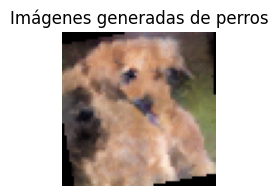

In [38]:
fake_dogs_images_loaded = []
with torch.no_grad():
    for _ in range(len(dogs_loader)):
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG_dogs_loaded(noise)
        fake_dogs_images_loaded.append(fake.cpu())
fake_dogs_dataset_loaded = torch.utils.data.TensorDataset(torch.cat(fake_dogs_images_loaded))
fake_dogs_loader_loaded = torch.utils.data.DataLoader(fake_dogs_dataset_loaded, batch_size=batch_size)

plt.figure(figsize=(2,2))
plt.axis("off")
plt.title("Imágenes generadas de perros")
plt.imshow(np.transpose(vutils.make_grid(fake_dogs_images_loaded[-1][0], padding=2, normalize=True), (1,2,0)))
plt.show()

### Gatos

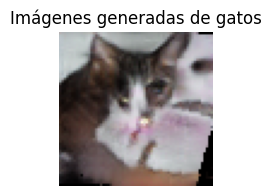

In [89]:
fake_cats_images_loaded = []
with torch.no_grad():
    for _ in range(len(cats_loader)):
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG_cats_loaded(noise)
        fake_cats_images_loaded.append(fake.cpu())
fake_cats_dataset_loaded = torch.utils.data.TensorDataset(torch.cat(fake_cats_images_loaded))
fake_cats_loader_loaded = torch.utils.data.DataLoader(fake_cats_dataset_loaded, batch_size=batch_size)

plt.figure(figsize=(2,2))
plt.axis("off")
plt.title("Imágenes generadas de gatos")
plt.imshow(np.transpose(vutils.make_grid(fake_cats_images_loaded[-1][0], padding=2, normalize=True), (1,2,0)))
plt.show()